In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
original_data_dir = '/content/drive/MyDrive/Garbage classification'
base_dir = "processed_dataset"

In [ ]:

classes = ["cardboard", "glass", "metal", "paper", "plastic"]


In [ ]:
os.makedirs(base_dir, exist_ok=True)
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

for split in [train_dir, val_dir, test_dir]:
    for cls in classes:
        os.makedirs(os.path.join(split, cls), exist_ok=True)


In [ ]:
for split in [train_dir, val_dir, test_dir]:
    for cls in classes:
        os.makedirs(os.path.join(split, cls), exist_ok=True)


In [ ]:
import shutil
for cls in classes:
    cls_dir = os.path.join(original_data_dir, cls)
    images = os.listdir(cls_dir)
    train_imgs, temp_imgs = train_test_split(images, test_size=0.4, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for img in train_imgs:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(train_dir, cls, img))
    for img in val_imgs:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(val_dir, cls, img))
    for img in test_imgs:
        shutil.copy(os.path.join(cls_dir, img), os.path.join(test_dir, cls, img))

print("Dataset organized into train, validation, and test splits.")


Dataset organized into train, validation, and test splits.


In [ ]:
image_size = (224, 224)
batch_size = 32
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=45,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.3,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.1,
    brightness_range=[0.8, 1.2],
    channel_shift_range=20.0
    )


In [ ]:
train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=classes
)

Found 1432 images belonging to 5 classes.


In [ ]:

val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=classes
)

Found 478 images belonging to 5 classes.


In [ ]:
test_gen = datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    classes=classes
)

Found 480 images belonging to 5 classes.


In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

base_model.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)
# x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(5, activation='softmax', dtype='float32')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=output_layer)


In [ ]:
# Callbacks
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    verbose=1
)

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy

alpha = 0.25
gamma = 2.0

def focal_loss(alpha, gamma):
    def loss(y_true, y_pred):
        ce_loss = CategoricalCrossentropy()(y_true, y_pred)
        pt = tf.reduce_sum(y_true * y_pred, axis=-1)
        fl = alpha * tf.pow(1.0 - pt, gamma) * ce_loss
        return tf.reduce_mean(fl)
    return loss

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=focal_loss(alpha=0.25, gamma=2.0),
    metrics=['accuracy']
)


In [ ]:
from sklearn.utils import class_weight

class_indices = train_gen.class_indices
num_classes = len(class_indices)


class_labels = list(class_indices.keys())

class_counts = np.zeros(num_classes)
for i, label in enumerate(class_labels):
    class_counts[i] = sum(train_gen.classes == i)

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weight_dict = {class_labels[i]: class_weights[i] for i in range(num_classes)}

print("Class weights: ", class_weight_dict)

Class weights:  {'cardboard': 1.1883817427385892, 'glass': 0.9546666666666667, 'metal': 1.1642276422764228, 'paper': 0.8044943820224719, 'plastic': 0.9910034602076124}


In [ ]:
 #class_weights = {0: 1.167479674796748, 1:0.9541528239202658, 2:0.8044817927170869, 3: 1.1867768595041321, 4:0.9903448275862069}  # Adjust based on class distribution

history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=[early_stopping,reduce_lr]
)

for layer in model.layers[-60:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=focal_loss(alpha=0.25, gamma=2.0),
    metrics=['accuracy']
)

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.3772 - loss: 0.2072 - val_accuracy: 0.7301 - val_loss: 0.0698 - learning_rate: 1.0000e-04
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 33s 665ms/step - accuracy: 0.7014 - loss: 0.0660 - val_accuracy: 0.7824 - val_loss: 0.0406 - learning_rate: 1.0000e-04
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 685ms/step - accuracy: 0.7473 - loss: 0.0455 - val_accuracy: 0.7887 - val_loss: 0.0308 - learning_rate: 1.0000e-04
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 719ms/step - accuracy: 0.7755 - loss: 0.0369 - val_accuracy: 0.8117 - val_loss: 0.0256 - learning_rate: 1.0000e-04
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 32s 649ms/step - accuracy: 0.7755 - loss: 0.0318 - val_accuracy: 0.7992 - val_loss: 0.0278 - learning_rate: 1.0000e-04
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 33s 669ms/step - accuracy: 0.7797 - loss: 0.0292 - val_accuracy: 0.8033 - val_loss: 0.0236 - learning_rate: 1.0000e-04
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 32s 641ms/step - accuracy: 0.8097 

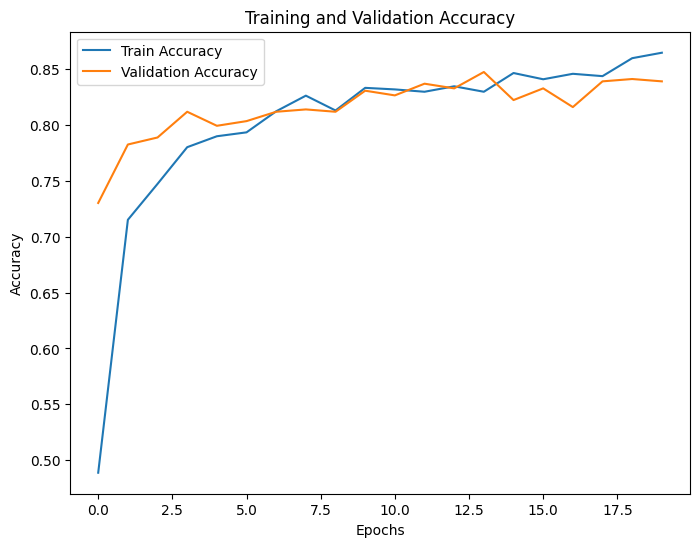

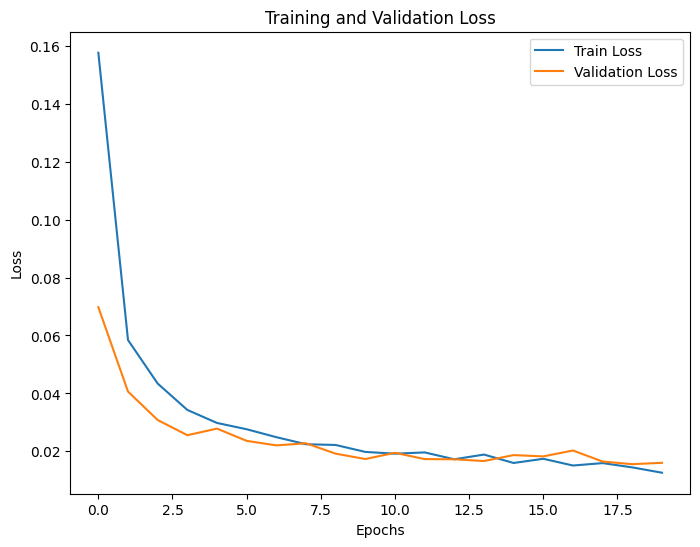

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 587ms/step - accuracy: 0.9020 - loss: 0.0120
Test Accuracy: 0.8917
Test Loss: 0.0117


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 532ms/step


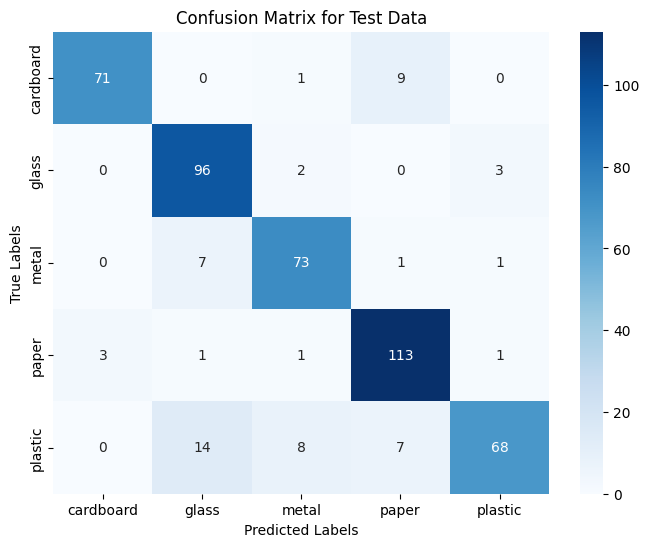

In [ ]:
# 7. **Confusion Matrix**
test_gen.reset()
test_predictions = model.predict(test_gen)
y_test_pred = np.argmax(test_predictions, axis=1)
y_test_true = test_gen.classes

cm_test = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.title('Confusion Matrix for Test Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
# Generate the classification report
class_labels = list(test_gen.class_indices.keys())
report = classification_report(y_test_true, y_test_pred, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

   cardboard       0.96      0.88      0.92        81
       glass       0.81      0.95      0.88       101
       metal       0.86      0.89      0.87        82
       paper       0.87      0.95      0.91       119
     plastic       0.93      0.70      0.80        97

    accuracy                           0.88       480
   macro avg       0.89      0.87      0.87       480
weighted avg       0.88      0.88      0.88       480



15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 427ms/step


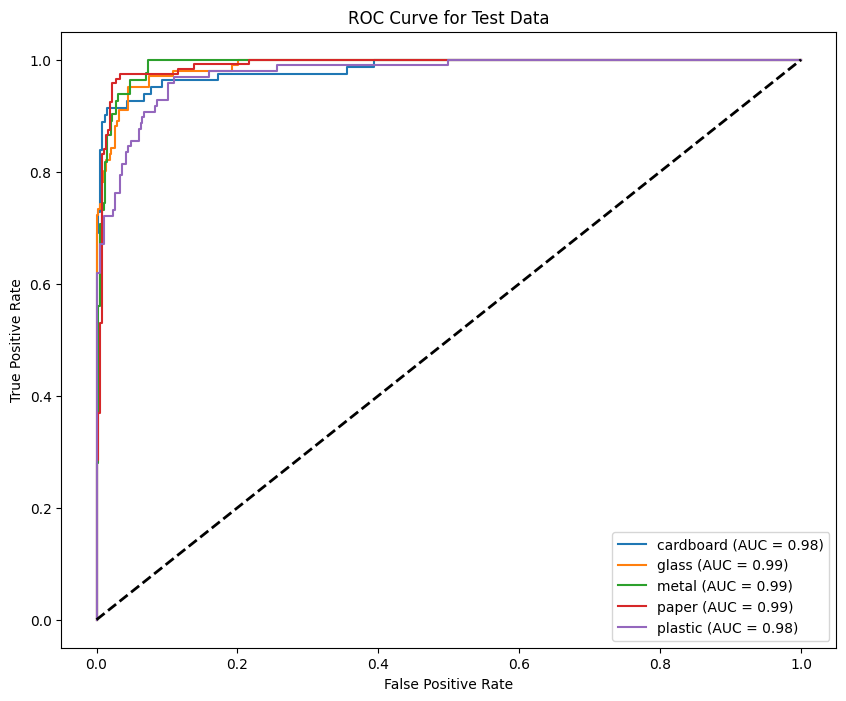

In [ ]:
# 9. **Plot ROC Curve**
test_predictions_proba = model.predict(test_gen)
fpr = {}
tpr = {}
roc_auc = {}
for i in range(test_gen.num_classes):
    fpr[i], tpr[i], _ = roc_curve(tf.keras.utils.to_categorical(y_test_true, test_gen.num_classes)[:, i], test_predictions_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i, label in enumerate(test_gen.class_indices.keys()):
    plt.plot(fpr[i], tpr[i], label=f'{label} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Data')
plt.legend(loc='best')
plt.show()